## Plotting benchmark results for PrivacyGLUE

PrivacyGLUE is a Natural Language Understanding benchmark which determines the performance of models in the privacy domain by fine-tuning, testing and measuring their performance on tasks related to analysis of privacy documents.
In this notebook we visualize the benchmark performance of 5 selected transformer-based models.

In [1]:
import json
import os

import matplotlib
import pandas as pd
import scipy
from plotnine import (
    aes,
    element_blank,
    element_text,
    facet_wrap,
    geom_errorbar,
    geom_line,
    geom_pointrange,
    geom_text,
    ggplot,
    guide_legend,
    guides,
    labs,
    position_dodge,
    scale_color_manual,
    theme,
    theme_bw,
)

%matplotlib inline
matplotlib.rc("text", usetex=True)

First we get the metrics from the runs directory and arange them in a pandas dataframe.

In [2]:
# declare global variables
MODELS = {
    "bert_base_uncased": "BERT",
    "roberta_base": "RoBERTa",
    "nlpaueb_legal_bert_base_uncased": "Legal-BERT",
    "saibo_legal_roberta_base": "Legal-RoBERTa",
    "mukund_privbert": "PrivBERT",
}

TASKS = {
    "opp_115": "\\textbf{OPP-115}",
    "piextract": "\\textbf{PI-Extract}",
    "policy_detection": "\\textbf{Policy-Detection}",
    "policy_ie_a": "\\textbf{PolicyIE-A}",
    "policy_ie_b": "\\textbf{PolicyIE-B}",
    "policy_qa": "\\textbf{PolicyQA}",
    "privacy_qa": "\\textbf{PrivacyQA}",
}

METRICS = {
    "macro_f1": "Macro F$_1$",
    "micro_f1": "Micro F$_1$",
    "sample_f1": "Sample F$_1$",
    "exact_match": "Exact Match",
}


# collect all data into list of dictionaries
all_results = []
for model in MODELS:
    with open(
        os.path.join("..", "runs", model, "benchmark_summary.json"), "r"
    ) as summary_file:
        model_results = json.load(summary_file)
        for task, task_dict in model_results.items():
            row_dict = {"mean": [], "std": [], "metric": [], "samples": []}
            row_dict["model_name"] = MODELS[model]
            row_dict["task"] = TASKS[task]
            row_dict["num_samples"] = task_dict["num_samples"]
            for index, metric in enumerate(task_dict["metrics"]):
                if metric in ["macro_f1", "micro_f1", "sample_f1", "exact_match"]:
                    row_dict["metric"].append(METRICS[metric])
                    row_dict["samples"].append(task_dict["samples"][index])
                    for statistic in ["mean", "std"]:
                        multiplier = 100 if task != "policy_qa" else 1
                        row_dict[statistic].append(
                            task_dict[statistic][index] * multiplier
                        )
            all_results.append(row_dict)

# convert into pandas dataframe
all_results = (
    pd.DataFrame(all_results)
    .apply(pd.Series.explode)
    .reset_index(drop=True)
    .infer_objects()
)
all_results = all_results.assign(
    metric=pd.Categorical(all_results["metric"], list(METRICS.values()))
)
all_results = all_results.assign(
    model_name=pd.Categorical(all_results["model_name"], list(MODELS.values()))
)

In [3]:
# define significance test
def test_significance(group):
    group["priv_bert_significance"] = ""
    priv_bert_samples = group.loc[group["model_name"] == "PrivBERT"]["samples"].item()
    significance_collection = {0.05: [], 0.01: [], 0.001: []}
    for index, row in group.iterrows():
        if row["model_name"] != "PrivBERT":
            other_model_samples = row["samples"]
            test = scipy.stats.mannwhitneyu(
                priv_bert_samples, other_model_samples, alternative="greater"
            )
            significance_collection[0.05].append(
                test.pvalue <= 0.05 and test.statistic >= 0
            )
            significance_collection[0.01].append(
                test.pvalue <= 0.01 and test.statistic >= 0
            )
            significance_collection[0.001].append(
                test.pvalue <= 0.001 and test.statistic >= 0
            )

    if all(significance_collection[0.001]) and significance_collection[0.001]:
        group.loc[group["model_name"] == "PrivBERT", "priv_bert_significance"] = "***"
    elif all(significance_collection[0.01]) and significance_collection[0.01]:
        group.loc[group["model_name"] == "PrivBERT", "priv_bert_significance"] = "**"
    elif all(significance_collection[0.05]) and significance_collection[0.05]:
        group.loc[group["model_name"] == "PrivBERT", "priv_bert_significance"] = "*"

    return group

In [4]:
# apply significance testing
all_results = all_results.groupby(["task", "metric"], group_keys=False).apply(
    test_significance
)

In [5]:
all_results["mean_pm_std"] = (
    all_results["mean"].round(1).astype(str)
    + "$\\pm$"
    + all_results["std"].round(1).astype(str)
)
all_results[["task", "metric", "mean_pm_std", "model_name"]].pivot(
    index=["task", "metric"], columns="model_name"
)

mean_pm_std                \
model_name                                      BERT       RoBERTa   
task                      metric                                     
\textbf{OPP-115}          Macro F$_1$   78.4$\pm$0.6  79.5$\pm$1.1   
                          Micro F$_1$   84.0$\pm$0.5  85.4$\pm$0.5   
\textbf{PI-Extract}       Macro F$_1$   60.0$\pm$2.7  62.4$\pm$4.4   
                          Micro F$_1$   60.0$\pm$2.7  62.4$\pm$4.4   
\textbf{Policy-Detection} Macro F$_1$   85.3$\pm$1.8  86.9$\pm$1.3   
                          Micro F$_1$   92.1$\pm$1.2  92.7$\pm$0.8   
\textbf{PolicyIE-A}       Macro F$_1$   72.9$\pm$1.7  73.2$\pm$1.6   
                          Micro F$_1$   84.7$\pm$1.0  84.8$\pm$0.6   
\textbf{PolicyIE-B}       Macro F$_1$   50.3$\pm$0.7  52.8$\pm$0.6   
                          Micro F$_1$   50.3$\pm$0.5  54.5$\pm$0.7   
\textbf{PolicyQA}         Sample F$_1$  55.7$\pm$0.5  57.4$\pm$0.4   
                          Exact Match   28.0$\pm$0.9  30.0$\pm$0.5   
\textbf{PrivacyQA}        Macro F$_1$   53.6$\pm$0.8  54.4$\pm$0.3   
                          Micro F$_1$   90.0$\pm$0.1  90.2$\pm$0.0   

                                                                    \
model_name                                Legal-BERT Legal-RoBERTa   
task                      metric                                     
\textbf{OPP-115}          Macro F$_1$   79.6$\pm$1.0  79.1$\pm$0.7   
                          Micro F$_1$   84.3$\pm$0.7  84.7$\pm$0.3   
\textbf{PI-Extract}       Macro F$_1$   59.5$\pm$3.0  60.5$\pm$3.9   
                          Micro F$_1$   59.5$\pm$3.0  60.5$\pm$3.9   
\textbf{Policy-Detection} Macro F$_1$   86.6$\pm$1.0  86.4$\pm$2.0   
                          Micro F$_1$   92.7$\pm$0.5  92.4$\pm$1.3   
\textbf{PolicyIE-A}       Macro F$_1$   73.2$\pm$1.5  73.5$\pm$1.5   
                          Micro F$_1$   84.7$\pm$0.5  84.8$\pm$0.3   
\textbf{PolicyIE-B}       Macro F$_1$   51.5$\pm$0.7  53.5$\pm$0.5   
                          Micro F$_1$   52.2$\pm$1.0  53.6$\pm$0.9   
\textbf{PolicyQA}         Sample F$_1$  55.3$\pm$0.7  56.3$\pm$0.6   
                          Exact Match   27.5$\pm$0.6  28.6$\pm$0.9   
\textbf{PrivacyQA}        Macro F$_1$   53.6$\pm$0.8  54.4$\pm$0.5   
                          Micro F$_1$   90.1$\pm$0.1  90.2$\pm$0.1   

                                                      
model_name                                  PrivBERT  
task                      metric                      
\textbf{OPP-115}          Macro F$_1$   82.1$\pm$0.5  
                          Micro F$_1$   87.2$\pm$0.4  
\textbf{PI-Extract}       Macro F$_1$   66.4$\pm$3.4  
                          Micro F$_1$   66.4$\pm$3.4  
\textbf{Policy-Detection} Macro F$_1$   87.3$\pm$1.1  
                          Micro F$_1$   92.9$\pm$0.8  
\textbf{PolicyIE-A}       Macro F$_1$   75.3$\pm$2.2  
                          Micro F$_1$   86.2$\pm$1.0  
\textbf{PolicyIE-B}       Macro F$_1$   55.4$\pm$0.7  
                          Micro F$_1$   55.7$\pm$1.3  
\textbf{PolicyQA}         Sample F$_1$  59.3$\pm$0.5  
                          Exact Match   31.4$\pm$0.6  
\textbf{PrivacyQA}        Macro F$_1$   55.3$\pm$0.6  
                          Micro F$_1$   90.2$\pm$0.1

Then we visualize all our metrics:

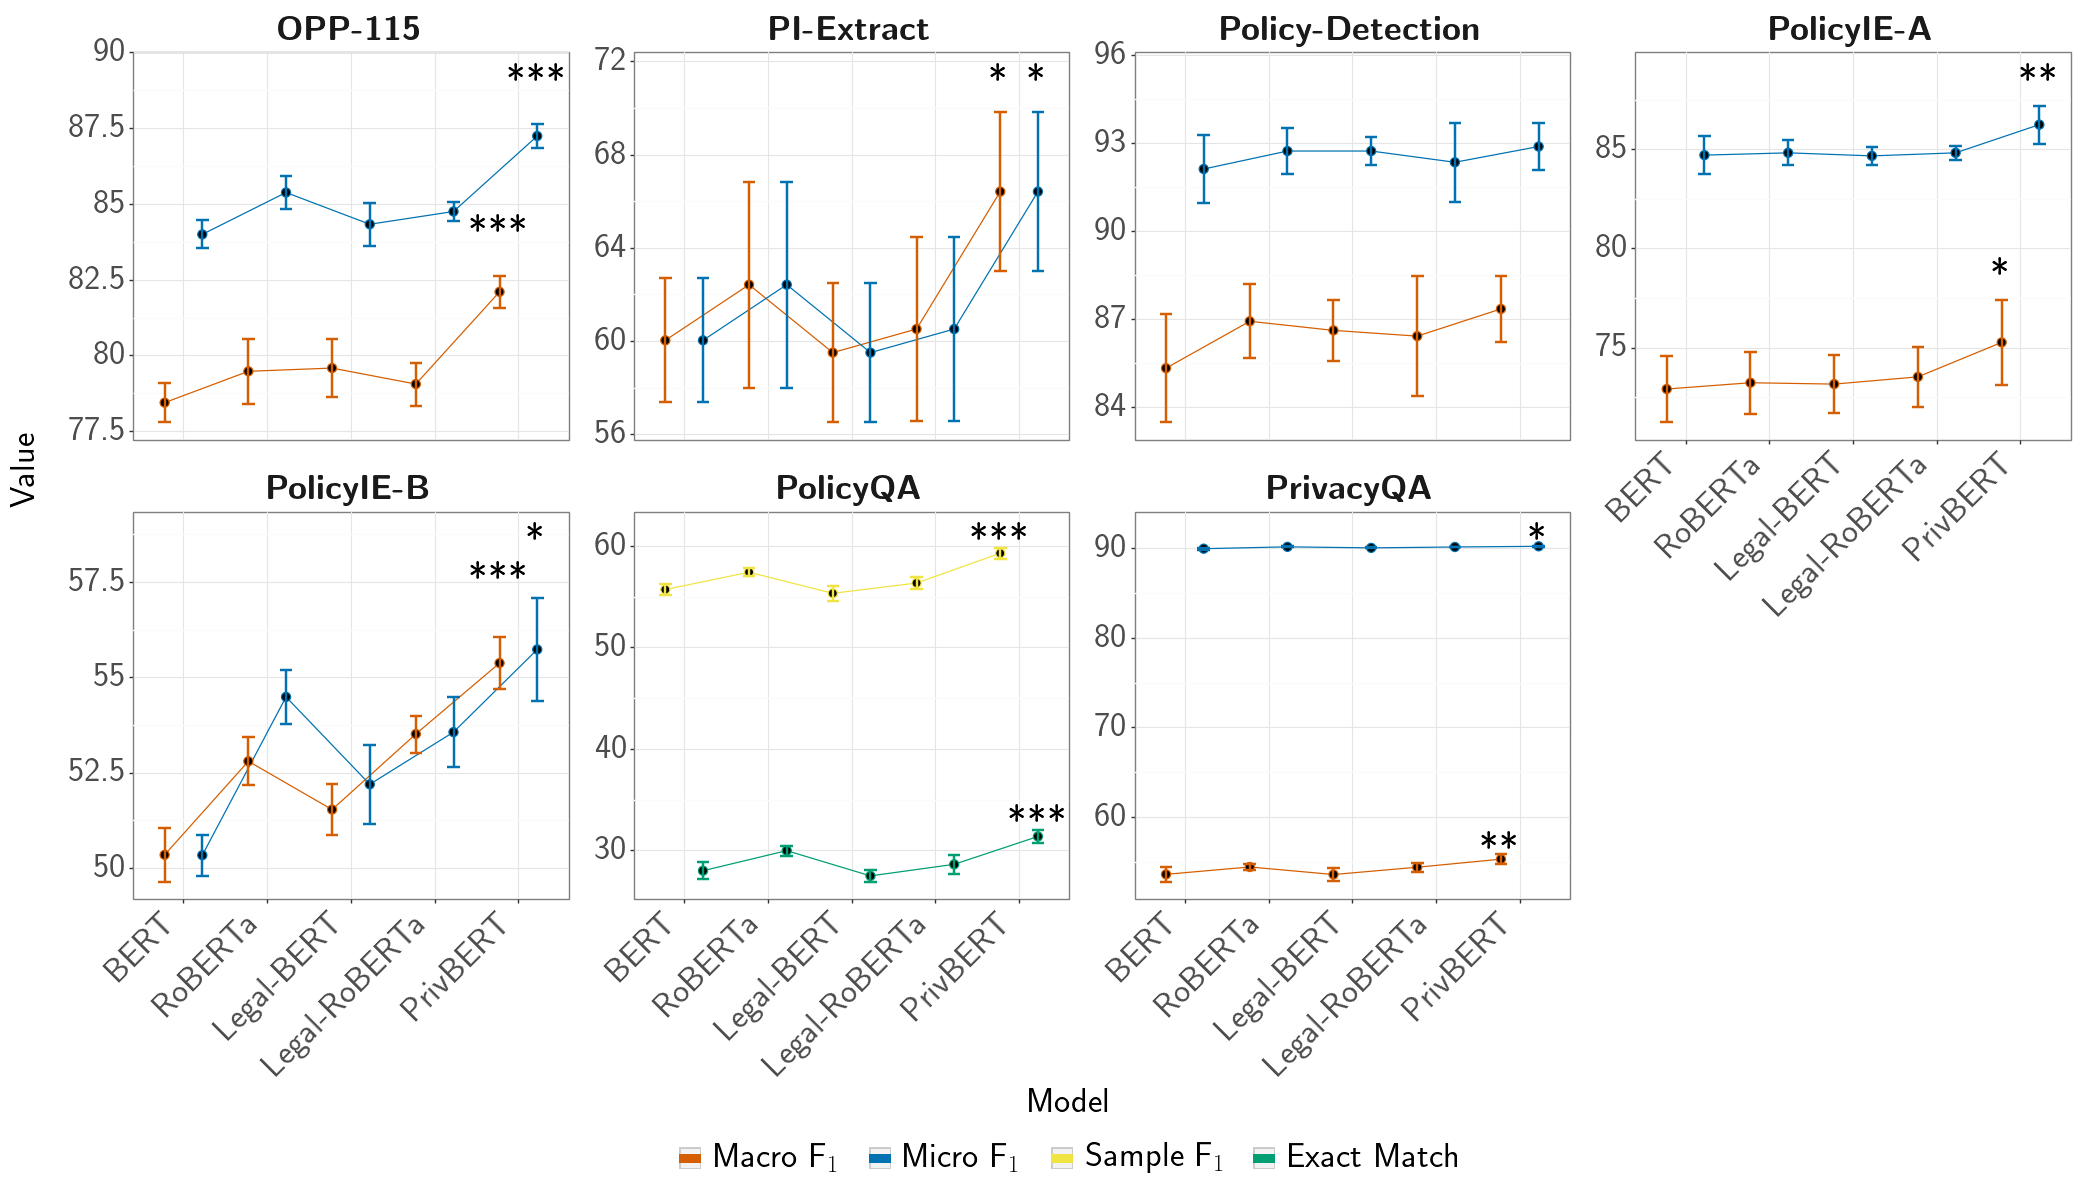

In [6]:
# plot ggplot object
(
    ggplot(all_results, aes(x="model_name", y="mean", group="metric", color="metric"))
    + geom_line(position=position_dodge(width=0.9))
    + geom_pointrange(
        mapping=aes(ymin="mean + std", ymax="mean - std"),
        position=position_dodge(width=0.9),
        size=0.8,
        fill="black",
        show_legend=False,
    )
    + geom_errorbar(
        mapping=aes(ymin="mean + std", ymax="mean - std"),
        position=position_dodge(width=0.9),
        width=0.3,
        size=1,
    )
    + geom_text(
        mapping=aes(label="priv_bert_significance", y="mean + std + 1.8"),
        position=position_dodge(width=0.9),
        size=30,
        color="black",
    )
    + facet_wrap("task", ncol=4, scales="free_y")
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, ha="right"),
        axis_title_y=element_text(margin={"r": 20}),
        figure_size=(25, 11),
        panel_spacing_y=0.3,
        text=element_text(size=25),
        legend_text=element_text(margin={"l": 10}),
        legend_position=(0.5, -0.125),
        legend_direction="horizontal",
        legend_title=element_blank(),
        legend_entry_spacing=20,
        strip_background=element_blank(),
        subplots_adjust={"wspace": 0.15},
    )
    + scale_color_manual(
        values=list(reversed(["#009e73", "#f0e442", "#0072b2", "#d55e00"]))
    )
    + labs(x="Model", y="Value")
    + guides(color=guide_legend(override_aes={"size": 3}))
).draw();

Finally, we compute three types of means on all metrics per model.

In [7]:
all_results.groupby("model_name")["mean"].agg(
    a_mean=scipy.mean, g_mean=scipy.stats.gmean, h_mean=scipy.stats.hmean
).round(1)

,a_mean,g_mean,h_mean
model_name,,,
BERT,67.5,64.6,61.1
RoBERTa,69.0,66.4,63.2
Legal-BERT,67.9,64.9,61.2
Legal-RoBERTa,68.5,65.7,62.3
PrivBERT,70.8,68.3,65.2
